In [211]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
STOP_WORDS = set(ENGLISH_STOP_WORDS)
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [212]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [213]:
df_train.shape

(49496, 11)

In [214]:
# Анализ пропусков
missing = df_train.isnull().sum()
missing_pct = 100 * missing / len(df_train)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct}).sort_values('Missing %', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

                      Missing Count  Missing %
product_bullet_point          19222  38.835461
product_color                 15293  30.897446
product_brand                  2091   4.224584
product_description               1   0.002020


Можно заполнить пропуски так

In [215]:
df_train["product_brand"] = df_train["product_brand"].fillna("unknown_brand")
df_train["product_color"] = df_train["product_color"].fillna("unknown_color")
df_test["product_brand"] = df_test["product_brand"].fillna("unknown_brand")
df_test["product_color"] = df_test["product_color"].fillna("unknown_color")

In [216]:
df_train["relevance"].value_counts().sort_index()

relevance
0     8027
1     3189
2    17969
3    20311
Name: count, dtype: int64

In [217]:
df_train.groupby('query_id').size().describe()

count    3500.000000
mean       14.141714
std         2.427321
min        10.000000
25%        12.000000
50%        15.000000
75%        16.000000
max        20.000000
dtype: float64

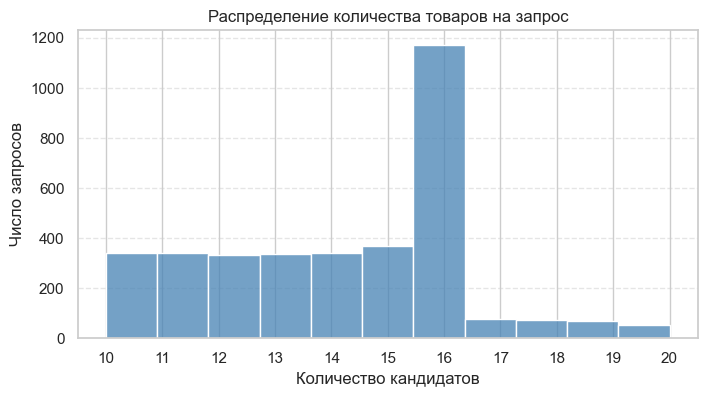

In [218]:
group_sizes = df_train.groupby('query_id').size()

plt.figure(figsize=(8, 4))
sns.histplot(group_sizes, bins=11, kde=False, color='steelblue')
plt.title('Распределение количества товаров на запрос')
plt.xlabel('Количество кандидатов')
plt.ylabel('Число запросов')
plt.xticks(range(10, 21))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Все запросы содержат от 10 до 20 кандидатов. Это гарантирует, что nDCG@10 может быть вычислен для 100% запросов, и модель обучается в сбалансированных условиях.

### **Распределение релевантности**

In [219]:
rel_counts = df_train['relevance'].value_counts().sort_index()
rel_pct = rel_counts / len(df_train) * 100
print(pd.DataFrame({'Count': rel_counts, 'Percentage (%)': rel_pct.round(1)}))

           Count  Percentage (%)
relevance                       
0           8027            16.2
1           3189             6.4
2          17969            36.3
3          20311            41.0


### **Анализ запросов**


**Длина запросов**

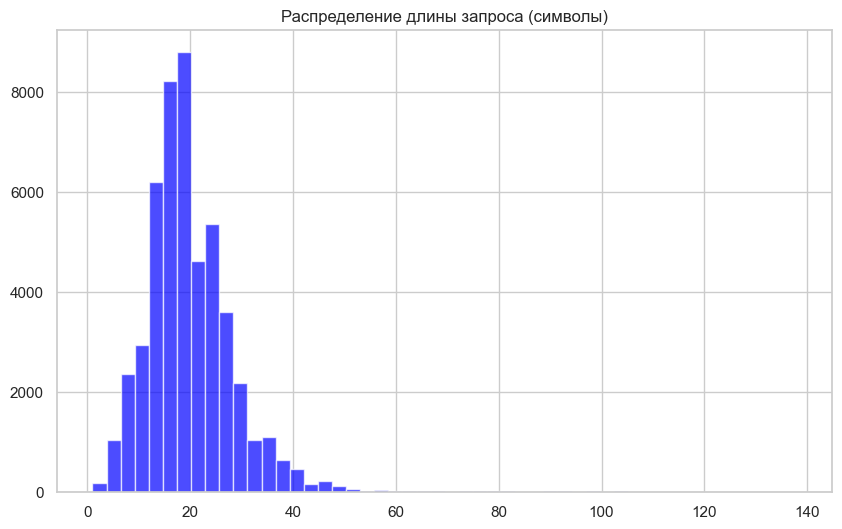

In [220]:
df_train["query_len"] = df_train["query"].str.len()
df_train["query_word_count"] = df_train["query"].str.split().str.len()

plt.hist(df_train["query_len"], bins=50, alpha=0.7, color='blue')
plt.title("Распределение длины запроса (символы)")
plt.show()

**Частота запросов**

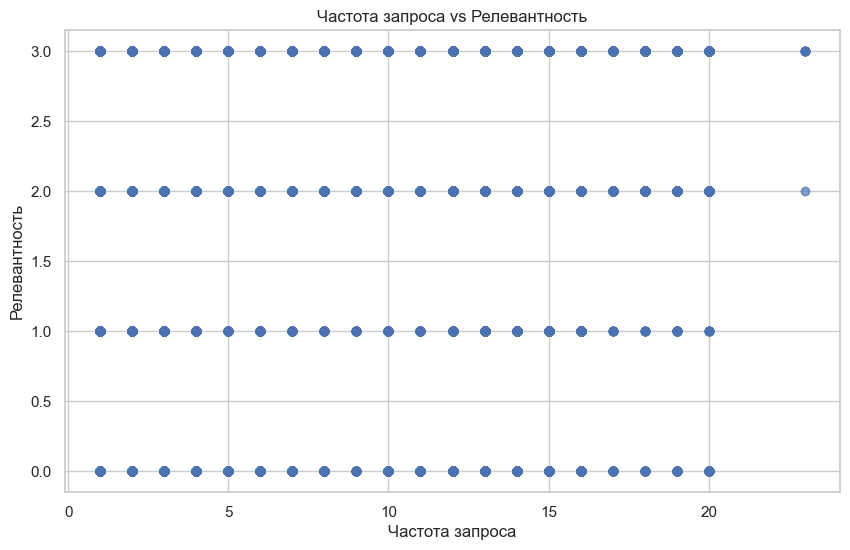

In [221]:
query_freq = df_train["query"].value_counts().reset_index()
query_freq.columns = ["query", "frequency"]

# Связь частоты запроса с релевантностью
df_train_with_freq = df_train.merge(query_freq, on="query", how="left")

plt.scatter(df_train_with_freq["frequency"], df_train_with_freq["relevance"], alpha=0.3)
plt.xlabel("Частота запроса")
plt.ylabel("Релевантность")
plt.title("Частота запроса vs Релевантность")
plt.show()

Популярные запросы (частота > 10) не обязательно более релевантны.
Редкие запросы (частота = 1–5) могут быть как очень релевантными (y=3), так и нерелевантными (y=0).

### **Анализ брендов и цветов**

**Бренд**

In [222]:
unique_brands = df_train["product_brand"].nunique()
unique_brands

18480

In [223]:
top_brands = df_train["product_brand"].value_counts().head(10)
top_brands

product_brand
unknown_brand          11982
Nike                     242
Apple                    157
adidas                   145
Hanes                    136
Samsung Electronics      130
Amazon Essentials        121
Amazon Basics            117
Under Armour             104
Rubie's                  100
Name: count, dtype: int64

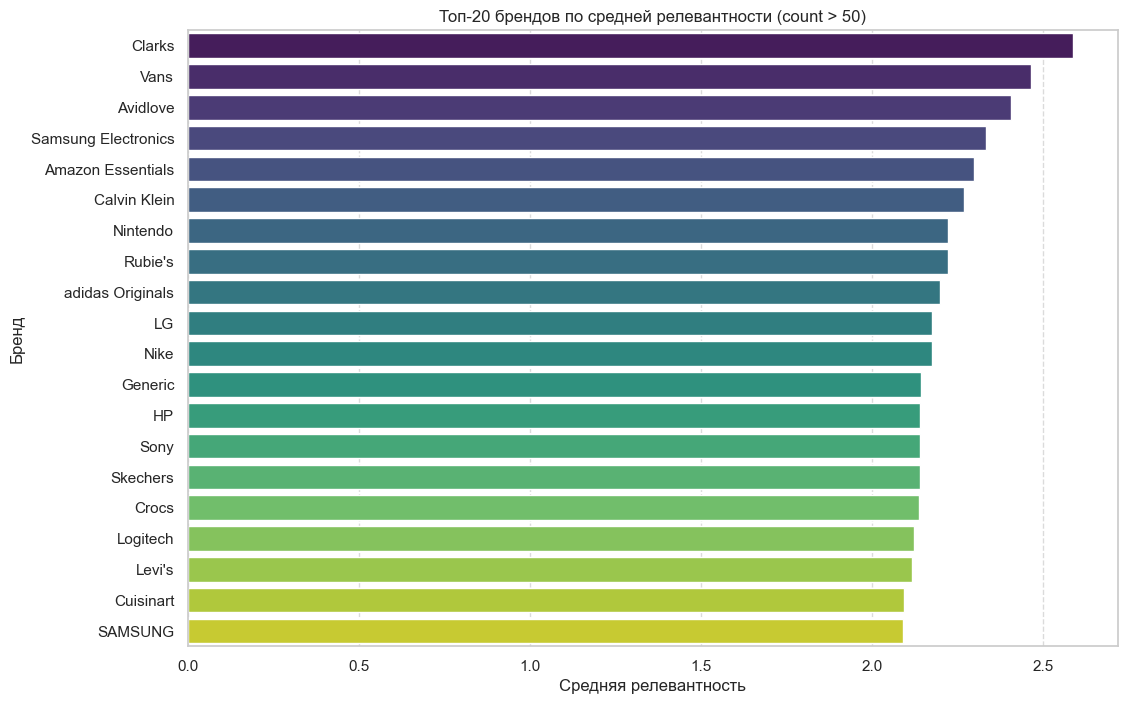

In [224]:
top_20_by_mean = brand_relevance.sort_values("mean", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_20_by_mean.reset_index(),
    x="mean",
    y="product_brand",
    hue="product_brand",
    palette="viridis",
    legend=False
)
plt.title("Топ-20 брендов по средней релевантности (count > 50)")
plt.xlabel("Средняя релевантность")
plt.ylabel("Бренд")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [225]:
# Какие бренды чаще всего релевантны?
brand_relevance = df_train.groupby("product_brand")["relevance"].agg(["mean", "count"]).sort_values("mean", ascending=False)
brand_relevance = brand_relevance[brand_relevance["count"] > 40] 

In [226]:
brand_relevance

,mean,count
product_brand,,
Clarks,2.586957,46
Vans,2.463415,41
Avidlove,2.403846,52
Samsung Electronics,2.330769,130
Amazon Essentials,2.297521,121
Calvin Klein,2.267606,71
Nintendo,2.222222,45
Rubie's,2.220000,100
adidas Originals,2.196970,66


Бинарный признак brand_in_query может стать сильным предиктором, так как релевантность при совпадении бренда на 60% выше

**Цвет**

In [227]:
df_train["product_color"].nunique() 

10962

In [228]:
df_train["clean_color"] = df_train["product_color"].str.lower().str.strip()

In [229]:
color_top = df_train["clean_color"].value_counts().head(40)
color_top

clean_color
unknown_color       15293
black                6112
white                2544
blue                  963
red                   748
multicolor            731
silver                725
clear                 546
grey                  519
pink                  492
green                 481
brown                 466
gray                  436
multi                 363
gold                  332
yellow                284
purple                222
navy                  220
orange                189
stainless steel       147
beige                 146
rose gold             117
multicolored          113
black/white            95
natural                91
tan                    86
multi-colored          84
assorted               84
light blue             73
ivory                  73
navy blue              72
matte black            70
original version       66
charcoal               64
chrome                 64
burgundy               62
dark brown             61
as shown               55


In [230]:
# Средняя релевантность по цветам
color_relevance = df_train.groupby("clean_color")["relevance"].agg(["mean", "count"])
color_relevance = color_relevance[color_relevance["count"] > 100].sort_values("mean", ascending=False)

In [231]:
color_relevance

,mean,count
clean_color,,
beige,2.184932,146
purple,2.126126,222
multi,2.123967,363
silver,2.100690,725
navy,2.090909,220
rose gold,2.076923,117
gold,2.072289,332
pink,2.069106,492
white,2.062893,2544


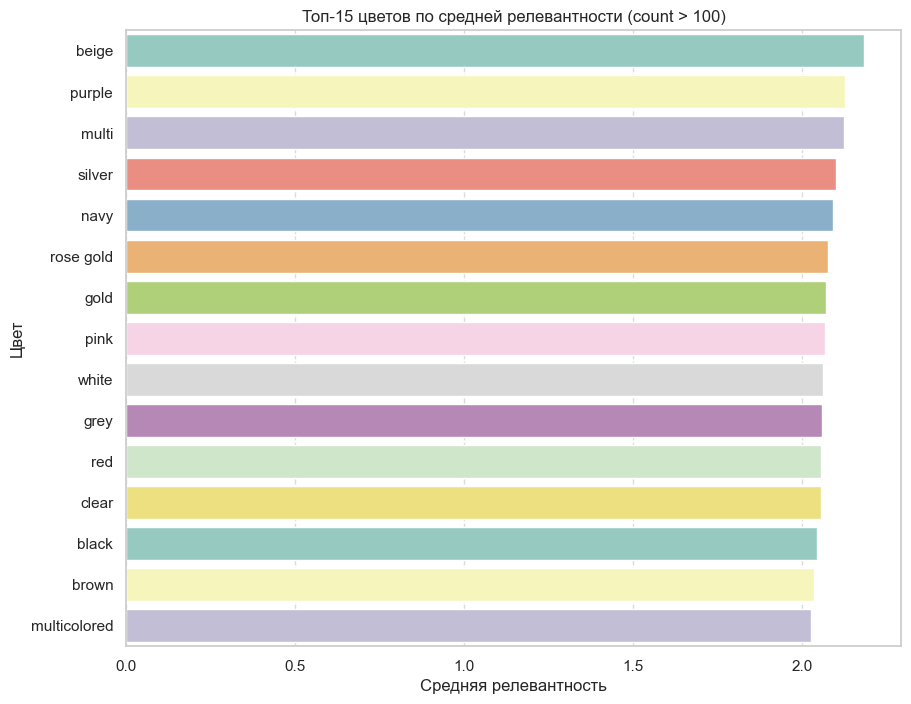

In [232]:
top_colors = color_relevance.head(15)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_colors.reset_index(),
    x="mean", y="clean_color",
    hue="clean_color", palette="Set3", legend=False
)
plt.title("Топ-15 цветов по средней релевантности (count > 100)")
plt.xlabel("Средняя релевантность")
plt.ylabel("Цвет")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

В данных присутствуют множественные варианты написания одного понятия:
multicolor, multicolored, multi — разные строки, но один смысл, а также grey и gray \
При этом multi имеет релевантность 2.12, а multicolor — всего 1.93, что указывает на разный контекст использования (премиум-товары vs дешёвые аксессуары). \
Это показывает, что нормализация категориальных полей могла бы дополнительно улучшить качество, но в финальном решении я ограничилась базовой очисткой. 

можно объединить 

In [233]:
df_train["clean_color"] = df_train["product_color"].fillna("unknown_color").str.lower().str.strip()

# Нормализация синонимов
color_mapping = {
    "grey": "gray",
    "multicolor": "multi",
    "multicolored": "multi",
    "multi-colored": "multi",
    "multi color": "multi",
    "stainless steel": "silver",
    "rose gold": "gold",
    "space gray": "gray",
    "matte black": "black",
    "navy blue": "blue",
    "light blue": "blue",
    "dark brown": "brown",
    "original version": "unknown_color",
    "as shown": "unknown_color",
    "clear": "transparent"
}

df_train["normalized_color"] = df_train["clean_color"].replace(color_mapping)

In [234]:
df_train["normalized_color"].unique()

array(['navy', 'clement blue', 'cat', ..., 'black with clear lens',
       'smoke windshield', 'vivid black outer batwing'], dtype=object)

In [235]:
color_top = df_train["normalized_color"].value_counts().head(10)
print("\nТоп-10 цветов:")
print(color_top)


Топ-10 цветов:
normalized_color
unknown_color    15414
black             6182
white             2544
multi             1344
blue              1108
gray              1009
silver             872
red                748
transparent        597
brown              527
Name: count, dtype: int64


**Взаимосвязь цвета и запроса**

In [236]:
def color_in_query(row):
    query_lower = row["query"].lower()
    color = row["clean_color"]
    if color == "unknown_color":
        return "no_color"
    elif color in query_lower:
        return "color_match"
    else:
        return "color_mismatch"

df_train["color_status"] = df_train.apply(color_in_query, axis=1)

color_effect = df_train.groupby("color_status")["relevance"].agg(["mean", "count"])

Несмотря на множество написаний, факт совпадения цвета с запросом (color_in_query) должен давать положительный сигнал, особенно для специфичных цветов вроде beige или rose gold.

### **Анализ текстовых полей: title, description, bullet**

**Наличие описания и его влияние**

In [237]:
df_train["has_description"] = df_train["product_description"].notna().astype(int)
df_train["has_bullet"] = df_train["product_bullet_point"].notna().astype(int)

desc_effect = df_train.groupby("has_description")["relevance"].mean()
bullet_effect = df_train.groupby("has_bullet")["relevance"].mean()

In [238]:
bullet_effect

has_bullet
0    1.984185
1    2.045319
Name: relevance, dtype: float64

**Длина текста и её корреляция с релевантностью**

In [239]:
def tokenize(text, min_len=2):
    if not isinstance(text, str) or not text.strip():
        return []
    tokens = re.findall(r"[a-z0-9]+", text.lower())
    return [t for t in tokens if t not in STOP_WORDS and len(t) >= min_len]

In [240]:
df_train["title_tokens"] = df_train["product_title"].apply(lambda x: len(tokenize(x)))
df_train["desc_tokens"] = df_train["product_description"].fillna("").apply(lambda x: len(tokenize(x)))
df_train["bullet_tokens"] = df_train["product_bullet_point"].fillna("").apply(lambda x: len(tokenize(x)))

corr = df_train[["relevance", "title_tokens", "desc_tokens", "bullet_tokens"]].corr()

In [241]:
df_train[["relevance", "title_tokens", "desc_tokens", "bullet_tokens"]].corr()

,relevance,title_tokens,desc_tokens,bullet_tokens
relevance,1.000000,0.010934,0.008431,0.012687
title_tokens,0.010934,1.000000,0.362737,0.378601
desc_tokens,0.008431,0.362737,1.000000,0.292851
bullet_tokens,0.012687,0.378601,0.292851,1.000000


In [242]:
def tokenize_to_set(text):
    """
    Безопасно токенизирует текст в множество.
    Обрабатывает NaN, bool, int и другие не-строки.
    """
    if not isinstance(text, str):
        return set()
    # Нормализуем и извлекаем токены
    tokens = re.findall(r"[a-z0-9]+", text.lower())
    return set(tokens)

# Применяем к колонкам — результат: Series из set'ов
query_tokens = df_train["query"].apply(tokenize_to_set)
title_tokens = df_train["product_title"].apply(tokenize_to_set)

# Рассчитываем пересечение и размер запроса
def safe_intersection_len(q_set, t_set):
    try:
        return len(q_set & t_set)
    except:
        return 0

def safe_len(s):
    try:
        return len(s)
    except:
        return 0

intersection_sizes = [safe_intersection_len(q, t) for q, t in zip(query_tokens, title_tokens)]
query_sizes = [safe_len(q) for q in query_tokens]

# Избегаем деления на ноль
overlap_ratios = [
    inter / max(1, qsize) for inter, qsize in zip(intersection_sizes, query_sizes)
]

# Сохраняем в датафрейм
df_train["overlap"] = overlap_ratios

# Анализ lexical gap
high_rel = df_train[df_train["relevance"] >= 2]
no_overlap = high_rel[high_rel["overlap"] == 0]
ratio = len(no_overlap) / len(high_rel) if len(high_rel) > 0 else 0

print(f"Релевантных без лексического совпадения: {len(no_overlap)} / {len(high_rel)} = {ratio:.1%}")

Релевантных без лексического совпадения: 7368 / 38280 = 19.2%


7 368 товаров из 38 280 с релевантностью ≥ 2 (19.2%) не содержат ни одного слова из пользовательского запроса. Это явление называют lexical gap — разрыв между формулировкой запроса и языком описания товара.

**Именно этот инсайт положил начало для дообучения cross-encoder на ranking-парах из трейна. Модель улавливает смысловую близость даже при полном отсутствии общих слов — и именно поэтому cross_encoder_score стал доминирующим признаком в ансамбле.**

Длинное описание не гарантирует высокую релевантность. \
Короткий заголовок не означает низкую релевантность.\
Бинарные признаки: has_desc, has_bullet — факт наличия информации,\
Семантические признаки: cross_encoder_score для качества содержания.


Высокая релевантность при совпадении бренда/цвета \
-> Можно добавить бинарные признаки: brand_in_query, color_in_query\
unknown_brand не снижает релевантность\
-> Можно оставить как категорию, не удалять\
Множество написаний цвета\
-> Попробовать провести базовую нормализацию (grey → gray и т.д.)

**Также было принято решение объединить title + bullet + description в единый текстовый признак \
Так как много пропусков в product_bullet_point (38.8%) и product_color (30.9%), а product_description почти всегда есть . \
Но даже если bullet или description отсутствуют — заголовок всегда есть.\
Объединение гарантирует, что:
у каждого товара есть полный текст для семантического сопоставления,\
cross-encoder и SBERT получают максимум информации,
не теряются релевантные сигналы из любого из полей.**